# 2D Multi-element airfoil

This assignment will investigate a 2D multi-element airfoil or wing section with an extended flap. This is adapting the source-vortex panel method from Lesson 11 to compute the flow around two airfoils 


**Key concepts** 
1. each airfoil has its own vortex strength 
2. the trailing edge of the airfoil must follow the Kutta condition. 


## Part 1: Williams' test case 

The test of the theoretical solution. We will use a more popular airfoil NACA23012 for both the main wing section and flap. 

**Task**: to calculate the pressure coefficient on a multi-element wing section 

### Defining the Geometry and Discretization

In [1]:
#importing the libraries and modules needed 
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

# integrate plots into the notebook 
%matplotlib inline 

In [2]:
# Importing the Data
MainFoil = numpy.genfromtxt('MainFoil_N=100.csv', delimiter =',')
FlapFoil = numpy.genfromtxt('FlapFoil_N=100.csv', delimiter = ',')

In [42]:
# Extracting Geometry from the Imported data
Main_x_ends, Flap_x_ends = MainFoil[:,0], FlapFoil[:,0]
Main_y_ends, Flap_y_ends = MainFoil[:,1], FlapFoil[:,1]

N = numpy.size(Main_x_ends)-1

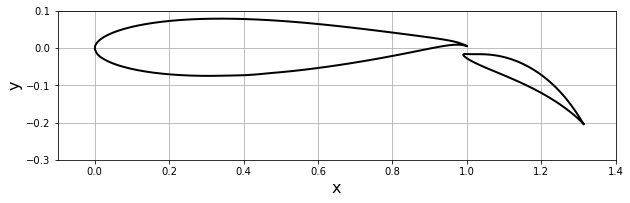

In [43]:
# Checking the geometry to see if it matches the diagram
width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x_ends,Main_y_ends,color='k', linestyle='-', linewidth=2)
pyplot.plot(Flap_x_ends, Flap_y_ends, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

Now that our geometry is loaded, We will calculate the velocities 

In [5]:
class Panel: 
    """
    Contains information related to panel
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initialized the panel. 
        
        sets the end-points and calculates the center-point, length, 
        and angle (with x-axis) of the panel. 
        Defines if the panel is located on the upper or lower surface 
        of the panel. 
        Initialized the source-strength, tangential velocity and pressure
        coefficent of the panel to zero. 
        
        Parameters:
        -----------
        xa: float
            x-coordinate of the first end-point. 
        ya: float
            y-coordinate of the first end-point. 
        xb: float 
            x-coordinate of the second end-point. 
        yb: float 
            y-coordinate of the second end-point. 
        """
        
        self.xa, self.ya = xa, ya #panel starting-point 
        self.xb, self.yb = xb, yb #panel ending point 
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of panel (angle between x-axis and panels normal)
        if xb-xa <=0.0: 
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa >0.0: 
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper'
        else: 
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [57]:
# Defining Panels using the points given
Main_panels = numpy.empty(N, dtype = object)
Flap_panels = numpy.empty(N, dtype = object)
for i in range(N):
    Main_panels[i] = Panel(Main_x_ends[i], Main_y_ends[i], 
                          Main_x_ends[i+1], Main_y_ends[i+1])
    Flap_panels[i] = Panel(Flap_x_ends[i], Flap_y_ends[i], 
                           Flap_x_ends[i+1], Flap_y_ends[i+1])

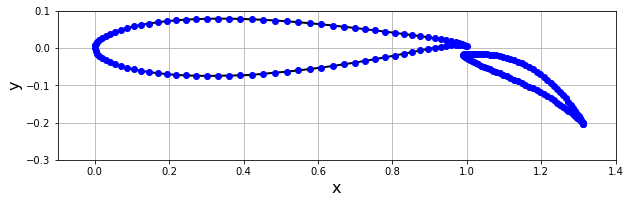

In [58]:
#plot the discretized geometry to check if panels are defined correctly
width= 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x_ends,Main_y_ends,color='k', linestyle = '-', linewidth=2)
pyplot.plot(Flap_x_ends,Flap_y_ends,color='k', linestyle = '-', linewidth=2)
for i in range(N-1): 
    pyplot.plot(Main_panels[i].xc, Main_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
    pyplot.plot(Flap_panels[i].xc, Flap_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

### Free stream Conditions

In [8]:
class Freestream: 
    """
    Freestream conditions. 
    """
    def __init__(self, u_inf =1.0, alpha =0.0):
        """
        Sets the freestream speed and angle (in degrees). 
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0. 
        alpha: float, optional
            Angle of attack in degrees; 
            default: 0.0. 
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0

In [45]:
# define freestream conditions 
freestream = Freestream(u_inf=1.0, alpha = 0.0)

### Flow tangency boundary condition, Enforcing Kutta condition, and Building the linear system

In [59]:
# define the function for the integral part of the equation 
def integral(x, y, panel, dxdk, dydk): 
    """
    Evaluates the contribution from a panel at a given point. 
    
    Parameters 
    ----------
    x: float
        x-coordinate of target point. 
    y: float 
        y-coodrinate of target point. 
    panel: Panel object 
        Panel whose contribution is evaluated. 
    dxdk: float 
        Value of the derivative of x in a certain direction. 
    dydk: float 
        Value of the derivative of y in a certain direction. 
    
    Returns 
    -------
    Contribution fro the panel at a given point (x, y)
    """
    def integrand(s): 
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
               / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

Defining the source contribution normal function

In [11]:
def source_contribution_normal(panels): 
    """
    Builds the source contribution matrix for the normal velocity. 
    
    Parameters
    -----------
    panels: 1D array of Panel objects
        list of panels. 
    
    Returns 
    -------
    A: 2D Numpy array of floats
        Source contribution matrix
    """
    A = numpy.empty((panels.size, panels.size), dtype = float)
    # source contribution on a panel from itself 
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others 
    for i, panel_i in enumerate(panels): 
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                              panel_j, 
                                              numpy.cos(panel_i.beta), 
                                              numpy.sin(panel_i.beta))
    return A

In [60]:
# Define the vortex normal contribution
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [48]:
## Defining the panels

# Combining the panels for source calculation 
All_panels = numpy.append(Main_panels, Flap_panels)

#Defining source contribution 
A_source = source_contribution_normal(All_panels)

# Defining the vortex contribution
B_vortex = vortex_contribution_normal(All_panels)

# Breaking the individual for kutta condition


In [61]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty((2,A_source.shape[0]+2), dtype=float)

    A = numpy.empty((A_source.shape[0], A_source.shape[0]+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0,:] = A[0, :] + A[N-1, :]
    b[1,:] = A[N, :] + A[-1, :]

    return b

In [62]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)


    return A

In [63]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                              +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [66]:
# define the matrices
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(All_panels, freestream)

In [67]:
# Solve the linear equations 
sigmas = numpy.linalg.solve(A,b)

for i, panel in enumerate(All_panels):
    panel.sigma = sigmas[i]
gamma = sigmas[-2:]
gamma

#Accuracy check sum of the sources should be zero
accuracy = sum([panel.sigma*panel.length for panel in All_panels])
print('--> sum of source/sink strengths:', accuracy)


--> sum of source/sink strengths: -0.00174836054324


In [68]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    vt = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [69]:
# tangential velocity at each panel center.
compute_tangential_velocity(All_panels, freestream, gamma, 
                            A_source, B_vortex)

In [70]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

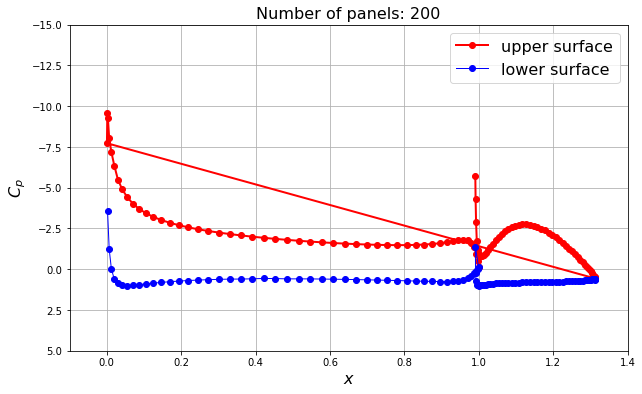

In [71]:
# surface pressure coefficient
compute_pressure_coefficient(All_panels, freestream)

# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in All_panels if panel.loc == 'upper'],
            [panel.cp for panel in All_panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in All_panels if panel.loc == 'lower'],
            [panel.cp for panel in All_panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(5.0, -15.0)
pyplot.title('Number of panels: {}'.format(All_panels.size), fontsize=16);

In [74]:
# Question 1 : What is the pressure coefficient on the 3rd panel on the
# main airfoil? 
print('Pressure coefficient on 3rd Panel: ', All_panels[2].cp)

Pressure coefficient on 3rd Panel:  -0.955701172981


In [75]:
# Question 2: What is the pressure coefficnet on the 10th panel on the 
# flap airfoil? 
print('Pressure coefficient on 10th Panel: ',All_panels[N+9].cp)

Pressure coefficient on 10th Panel:  -0.279918398369


In [76]:
# Questions 3: What is the value of lift?
Lift, Drag = 0.0,0.0
for panel in All_panels:
    Lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag += panel.cp*numpy.cos(panel.beta)*panel.length

print('Lift on the body is: ', Lift)
print('Drag on the body is: ', Drag)

Lift on the body is:  3.69771447686
Drag on the body is:  0.0107914032459


In [77]:
# Calculate the accuracy of the model
accuracy= sum([panel.sigma*panel.length for panel in All_panels])
print('sum of singularity strengths: {:0.6f}' .format(accuracy))

sum of singularity strengths: -0.001748


In [78]:
# Checking the error of the model
Lift_theo = 3.7386
Drag_theo = 0.0 

error = Lift_theo-Lift
print('Absolute Error: ', error)

Absolute Error:  0.0408855231392


In [79]:
AbsError100=  0.04088
AbsError200 = 0.020166

Improv = (AbsError100-AbsError200)/AbsError100
print('The improvement of error is ', Improv)

The improvement of error is  0.5067025440313112


## Part 2: Wenzinger's Test Case

Using the imported 150 panels on each foil

We can rotate the flap around point (xc, yc)

In [80]:
# Defining variables given
xc, yc = 1.03, -0.054    #rotations matrix 
N = 150                  # number of panels 

# Importing the geometries 
Main = numpy.genfromtxt('NACA23012_MainFoil.csv', delimiter = ',')
Flap = numpy.genfromtxt('NACA23012_FlapFoil.csv', delimiter = ',')

# Defining the end points 
Main_x, Main_y = Main[:,0], Main[:,1]
Flap_x, Flap_y = Flap[:,0], Flap[:,1]

In [82]:
def rotate_flap(x, y, xc, yc, theta): 
    """
    Rotates the flap around a certain point
    
    Parameters
    ----------
    Returns
    -------
    """
    theta = theta*numpy.pi/180.0
    x_new = ( xc + (x-xc)*numpy.cos(theta) -
             (y - yc)*numpy.sin(theta) )
    y_new = (yc + (x - xc)*numpy.sin(theta) +
            (y - yc)*numpy.cos(theta) )
    
    return x_new, y_new

In [99]:
def calculate_lift(Main_panels, Fx, Fy, xc, yc, AoA, theta):
    """
    """
    
    Fx_new, Fy_new = rotate_flap(Fx, Fy, xc, yc, theta)
    

    Flap_panels = numpy.empty(N, dtype=object)

    for i in range(N):
        Flap_panels[i] = Panel(Fx_new[i], Fy_new[i], 
                          Fx_new[i+1], Fy_new[i+1])

    panels = numpy.append(Main_panels, Flap_panels)
    
    freestream = Freestream(u_inf, AoA)
        
    A_s = source_contribution_normal(panels)
    B_v = vortex_contribution_normal(panels)
        
    A = build_singularity_matrix(A_s, B_v)
    b = build_freestream_rhs(panels, freestream)
        
    sigmas = numpy.linalg.solve(A,b)
        
    for i, panel in enumerate(panels):
        panel.sigma = sigmas[i]
    gamma = sigmas[-2:]
        
    compute_tangential_velocity(panels,freestream, gamma, A_s, B_v)
    compute_pressure_coefficient(panels, freestream)
        
    Lift =0.0    
    for panel in panels: 
        Lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    
    return Lift    

In [100]:
def Bisection_method_AoA(Main_panels, Fx, Fy, xc, yc, theta,
                         alpha1, alpha2, tol ):
    """
    Finds the Angle of attack with zero lift iteratively. 
    
    Parameters: 
    -----------
    panels: Panel object 
    alpha1: float
        beginning of range for search (in degrees)
    alpha2: float 
        end of range for search (in degrees)
    tol: float 
        tolerance of search
    
    Returns
    -------
    Angle: float 
        Angle of attack with zero lift 
    """
    
    n = 1 
    Lift_init = calculate_lift(Main_panels, Fx, Fy, xc, yc,
                                alpha1, theta)
    while n < 100: 
        alpha = 0.5*(alpha1+alpha2)
        Lift = calculate_lift(Main_panels, Fx, Fy, xc, yc, alpha,theta)
        print('Alpha: ', alpha, 'Lift: ', Lift, '# of iterations: ', n)
        
        if abs(alpha2-alpha1)/2 < tol: 
            print('Found it!')
            break
        
        
        if numpy.sign(Lift) == numpy.sign(Lift_init):
            alpha1 = alpha
            Lift_init=Lift
        else:
            alpha2 = alpha
    
        n = n+1
    return alpha

In [101]:
def Bisection_method_flap(Main_panels, fx, fy, theta1, 
                          theta2, xc, yc, AoA, tol): 
    """
    Calculates the flap angle where zero angle of attack 
    
    Parameters
    main_x: 1D numpy array
        x-coordinates of the end points of the main airfoil panels
    main_y: 1D numpy array
        y-coordinates of the end points of the main airfoil panels 
    flap_x: 1D numpy array 
        x-coordinates of the end points of the flap airfoil panels
    flap_y: 1D numpy array 
        y-coordinates of the end points of the flap airfoil panels
    theta1: float 
        start angle of the range of search range
    theta2: float 
        end angle of search range
    AoA: float 
        Angle of attack (default=0)
    tol: float
        tolerance of iterative search
        
    Returns
    -------
    theta: float
        angle of the flap with zero angle of attack 
    """   
    Lift_init = calculate_lift(Main_panels, fx, fy, xc, yc, AoA, theta1)
    
    Mpan = numpy.empty(N,dtype=object)
    Fpan = numpy.empty(N, dtype=object)
    
    n=1
    while n < 100: 
        theta = 0.5*(theta1+theta2)
        Lift = calculate_lift(Main_panels, fx, fy, xc, yc, AoA, theta)
        print('Theta: ', theta, 'Lift: ', Lift, '# of iterations: ', n)
        
        if abs(theta2-theta1)/2 < tol:
            print('Found it!')
            break
        
        if numpy.sign(Lift) == numpy.sign(Lift_init):
            theta1 = theta
            Lift_init=Lift
        else:
            theta2 = theta
    
        n = n+1
    return theta

In [102]:
Main_panels = numpy.empty(N, dtype=object)
for i in range(N):
    Main_panels[i] = Panel(Main_x[i], Main_y[i],
                           Main_x[i+1], Main_y[i+1])
    
theta = -20.0
u_inf = 1.0
alpha1, alpha2 = -14.0, 0.0

Lift_init = 0.0
Lift = 0.0

In [96]:
#Question 01: Wjat os the angle of attack that give zero lift with 
# tail angled 20 degrees?
AoA = Bisection_method_AoA(Main_panels, Flap_x, Flap_y, 
                                       xc, yc, theta,
                                       alpha1, alpha2, 0.01)

Alpha:  -7.0 Lift:  0.548338462552 # of iterations:  1
Alpha:  -10.5 Lift:  0.0634989062041 # of iterations:  2
Alpha:  -12.25 Lift:  -0.175476948754 # of iterations:  3
Alpha:  -11.375 Lift:  -0.0563695467263 # of iterations:  4
Alpha:  -10.9375 Lift:  0.00347652142469 # of iterations:  5
Alpha:  -11.15625 Lift:  -0.0264694255558 # of iterations:  6
Alpha:  -11.046875 Lift:  -0.0115020712276 # of iterations:  7
Alpha:  -10.9921875 Lift:  -0.00401416604986 # of iterations:  8
Alpha:  -10.96484375 Lift:  -0.000269168393877 # of iterations:  9
Alpha:  -10.951171875 Lift:  0.00160359020835 # of iterations:  10
Alpha:  -10.9580078125 Lift:  0.000667189303812 # of iterations:  11
Found it!


In [105]:
# Question 02: What is the flap deflection angle that gives zero lift 
# at zero angle of attack? 

theta1, theta2 = -10.0, 10.0     # search range
AoA = 0.0
theta = Bisection_method_flap(Main_panels, Flap_x, Flap_y, theta1, 
                          theta2, xc, yc, AoA, 0.01)

Theta:  0.0 Lift:  0.271910644469 # of iterations:  1
Theta:  5.0 Lift:  -0.0292849385314 # of iterations:  2
Theta:  2.5 Lift:  0.120733957722 # of iterations:  3
Theta:  3.75 Lift:  0.0455783940188 # of iterations:  4
Theta:  4.375 Lift:  0.00811001236125 # of iterations:  5
Theta:  4.6875 Lift:  -0.010596666081 # of iterations:  6
Theta:  4.53125 Lift:  -0.00124562455172 # of iterations:  7
Theta:  4.453125 Lift:  0.0034316198606 # of iterations:  8
Theta:  4.4921875 Lift:  0.00109285409623 # of iterations:  9
Theta:  4.51171875 Lift:  -7.64211232741e-05 # of iterations:  10
Theta:  4.501953125 Lift:  0.000508207513369 # of iterations:  11
Found it!


In [106]:
# Question03: How much slower?
AoA = 4.0

Lift = calculate_lift(Main_panels, Flap_x, Flap_y, xc, yc, AoA, 0.0)

In [120]:
Lift5 = calculate_lift(Main_panels, Flap_x, Flap_y, xc, yc, AoA, -5.0)
Lift10 = calculate_lift(Main_panels, Flap_x, Flap_y, xc, yc, AoA, -10.0)
Lift15 = calculate_lift(Main_panels, Flap_x, Flap_y, xc, yc, AoA, -15.0)

In [126]:
Lifts = [Lift5, Lift10, Lift15]
thetas = [-5, -10, -15]
for i in range(3):
    diff = (1 - 1/numpy.sqrt(Lifts[i]/Lift))*100
    print('Percentage Difference for flap angle ', thetas[i], 
         'is: ', diff)

Percentage Difference for flap angle  -5 is:  14.5141136357
Percentage Difference for flap angle  -10 is:  24.2124090158
Percentage Difference for flap angle  -15 is:  31.2809103274
